# CS189: Homework 1

## Import Packages

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm

## Load Datasets

In [22]:
data_dict = {}
for data_name in ["mnist", "spam", "toy"]:
    data = np.load(f"data/{data_name}-data.npz")
    print(f"loaded {data_name} data!")
    data_dict[data_name] = data

loaded mnist data!
loaded spam data!
loaded toy data!


## 2 Theory of Hard-Margin Support Vector Machines

Plot the data points and decision boundary when fitting the linear SVM to the `toy-data.npz` dataset.

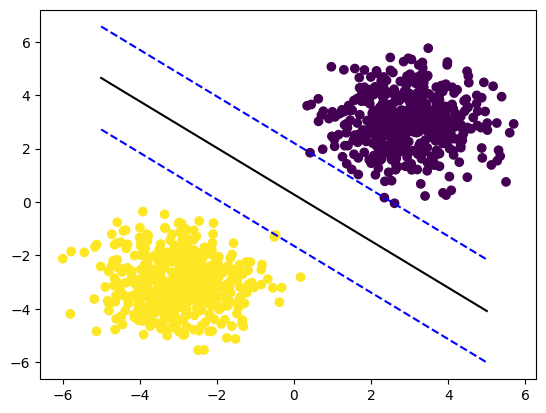

In [23]:
data = data_dict["toy"]
train_data = data["training_data"]
train_labels = data["training_labels"]

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels)

# Parameters for the linear SVM
w = [-0.4528, -0.5190]
b = 0.1471

# Plot the decision boundary
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1]
plt.plot(x, y, "k")

# Plot the margins
pos_y = (-w[0] * x + 1 - b) / w[1]
neg_y = (-w[0] * x - 1 - b) / w[1]
plt.plot(x, pos_y, "--b")
plt.plot(x, neg_y, "--b")

# Display plots
plt.show()

## Common methods

In [24]:
def do_standardize(test_data: np.ndarray, train_data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Standardizes the test and training data by scaling all pixel values to a range of [0, 1].

    Parameters:
    - test_data: The test dataset, with each sample's features needing to be standardized.
    - train_data: The training dataset, used to derive the overall min and max for standardization.

    Returns:
    - A tuple containing the standardized test and training datasets.
    """

    test_size = len(test_data)
    test_data = test_data.reshape(test_size, -1)
    train_data = train_data.reshape(len(train_data), -1)
    data = np.append(test_data, train_data, axis=0)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    return data[0:test_size, :], data[test_size:, :]


def results_to_csv(y_test: np.ndarray, data_name: str) -> None:
    """
    Saves test results to a CSV file with a specific format.

    Parameters:
    - y_test: The array of predicted labels for the test set. Labels are expected to be integers.
    - data_name: The base name to use for the CSV file.

    Returns:
    - None
    """
    y_test = y_test.astype(int)
    df = pd.DataFrame({"Category": y_test})
    df.index += 1  # Ensures that the index starts at 1
    df.to_csv(f"{data_name}_submission.csv", index_label="Id")


## 3 Data Partitioning and Evaluation Metrics

In [25]:
def partition_data(data_name: str) -> tuple[np.ndarray]:
    """
    Shuffles the dataset and partitions it into training and validation sets.

    Parameters:
    - data_name: Name of the dataset file (without path and extension).

    Returns:
    - tuple: (train_data, train_labels, val_data, val_labels).
    """
    
    dataset = data_dict[data_name]

    # Extract training data and labels from the file
    _, data = do_standardize(dataset["test_data"], dataset["training_data"])
    labels = dataset["training_labels"]

    num_samples = data.shape[0]
    assert num_samples == labels.shape[0]

    # Shuffle training data and labels
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    # Size of the validation set
    val_size = None
    if data_name == "mnist":
        val_size = 10000
    elif data_name == "spam":
        val_size = int(num_samples * 0.2)
    else:
        raise ValueError(f"The dataset {data_name} is not supported")    
    
    # Partition the dataset: the first `val_size` samples go to validation set
    val_data, val_labels = data[:val_size], labels[:val_size]

    # The remaining samples are used as the training set
    train_data, train_labels = data[val_size:], labels[val_size:]

    return train_data, train_labels, val_data, val_labels
    

def compute_accuracy_score(true_labels: np.ndarray, predicted_labels: np.ndarray) -> float:
    """
    Computes the accuracy score by comparing true labels with predicted labels.

    Parameters:
    - true_labels: Array of ground truth labels.
    - predicted_labels: Array of labels predicted by a model.

    Returns:
    - float: The accuracy score, representing the proportion of correct predictions.
    """
    
    # Ensure true and predicted labels match in length
    num_samples = true_labels.shape[0]
    assert num_samples > 0
    assert num_samples == predicted_labels.shape[0]

    total = 0
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        total += true_label == predicted_label

    return total / num_samples

## 4 Support Vector Machines: Coding

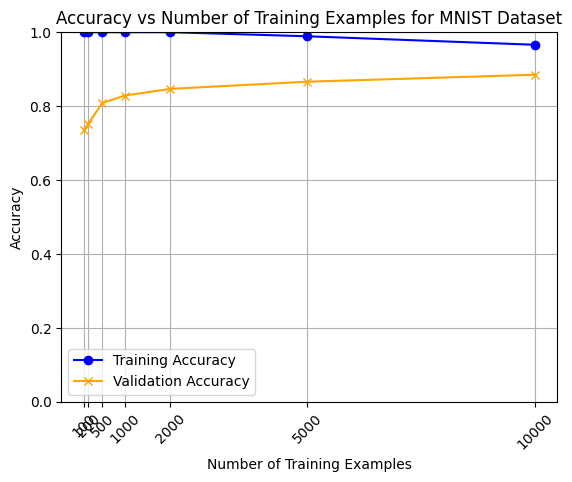

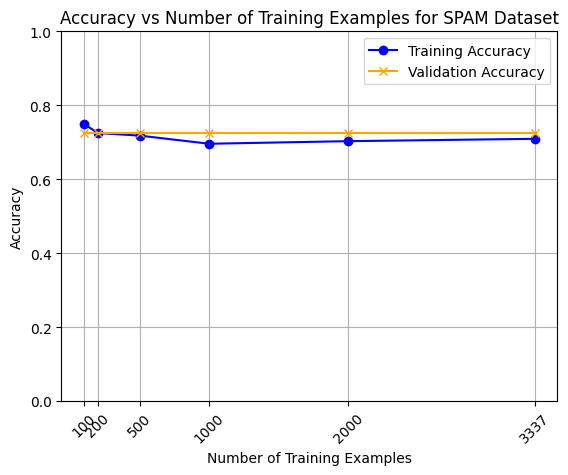

In [31]:
for data_name in ["mnist", "spam"]:
    train_data, train_labels, val_data, val_labels = partition_data(data_name)
    
    num_train_list = None
    if data_name == "mnist":
        num_train_list = [100, 200, 500, 1000, 2000, 5000, 10000]
    elif data_name == "spam":
        num_train_list = [100, 200, 500, 1000, 2000, train_data.shape[0]]
        
    model = svm.LinearSVC(dual=False)
    train_acc_list = []
    val_acc_list = []
    
    for num_samples in num_train_list:
        # Select the training samples
        train_x = train_data[:num_samples]
        train_y = train_labels[:num_samples]

        # Fit the model
        model.fit(train_x, train_y)

        # Calculate the training accuracy
        train_acc = compute_accuracy_score(train_y, model.predict(train_x))
        train_acc_list.append(train_acc)

        # Calculate the validation accuracy
        val_acc = compute_accuracy_score(val_labels, model.predict(val_data))
        val_acc_list.append(val_acc)

    plt.figure()
    plt.plot(num_train_list, train_acc_list, marker="o", label="Training Accuracy", color="blue")
    plt.plot(num_train_list, val_acc_list, marker="x", label="Validation Accuracy", color="orange")

    plt.title(f"Accuracy vs Number of Training Examples for {data_name.upper()} Dataset")
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Accuracy")
    # Show ticks for the number of training examples
    plt.xticks(ticks=num_train_list, labels=num_train_list, rotation=45)
    # Accuracy is between 0 and 1
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{data_name}.png", bbox_inches="tight")
    plt.show()

## 5 Hyperparameter Tuning

In [27]:
train_data, train_labels, val_data, val_labels = partition_data("mnist")

C_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
best_C = None
max_accuracy = 0

print("Accuracy scores for different C values:")
for C in C_values:
    model = svm.LinearSVC(dual=False, C=C)
    model.fit(train_data, train_labels)
    accuracy = compute_accuracy_score(val_labels, model.predict(val_data))
    print(f"  C={C}: {accuracy}")
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = C
    
print(f"The best C value is {best_C} with accuracy {max_accuracy}")

Accuracy scores for different C values:
  C=1e-05: 0.8286
  C=0.0001: 0.8813
  C=0.001: 0.9055
  C=0.01: 0.9123
  C=0.1: 0.9119
  C=1: 0.9125
  C=10: 0.9117
  C=100: 0.9106
The best C value is 1 with accuracy 0.9125


## 6 K-Fold Cross-Validation

In [28]:
dataset = data_dict["spam"]
data = dataset["training_data"]
labels = dataset["training_labels"]

num_samples = data.shape[0]
assert num_samples == labels.shape[0]

# Shuffle the training data
indices = np.arange(num_samples)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Run 5-fold cross-validation for 8 C values on the spam dataset
K = 5
fold_size = num_samples // K
C_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

max_accuracy = 0
best_C = None

print("Accuracy scores for different C values:")
for C in C_values:
    total = 0
    for k in range(K):
        start = k * fold_size
        end = (k + 1) * fold_size

        # Concatenate (k - 1) disjoint sets to form the training set
        train_data = np.append(data[:start, :], data[end:-1, :], axis=0)
        train_labels = np.append(labels[:start], labels[end:-1], axis=0)

        # Use the remaining set as the validation set
        val_data = data[start:end, :]
        val_labels = labels[start:end]

        # Train the SVM model
        model = svm.LinearSVC(dual=False, C=C)
        model.fit(train_data, train_labels)

        total += compute_accuracy_score(val_labels, model.predict(val_data))

    accuracy = total / K
    print(f"C={C}: {accuracy:.4f}")

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = C

print(f"The best C value is {best_C} with accuracy {max_accuracy}")

Accuracy scores for different C values:
C=1e-05: 0.7604
C=0.0001: 0.7607
C=0.001: 0.7755
C=0.01: 0.7978
C=0.1: 0.8046
C=1: 0.8077
C=10: 0.8096
C=100: 0.8094
C=1000: 0.8094
C=10000: 0.8094
The best C value is 10 with accuracy 0.8095923261390888


## 7 Kaggle
### 7.1 MNIST

In [29]:
dataset = data_dict["mnist"]
train_data, test_data = dataset["training_data"], dataset["test_data"]
train_data = train_data.reshape(len(train_data), -1)
test_data = test_data.reshape(len(test_data), -1)
train_labels = dataset["training_labels"]

C = 0.1
model = svm.SVC(C=C)

model.fit(train_data, train_labels)
train_acc = compute_accuracy_score(train_labels, model.predict(train_data))
print(f"Training Accuracy (C={C}): {train_acc}")
results_to_csv(model.predict(test_data), "mnist")


Training Accuracy (C=0.1): 0.9618666666666666


### 7.2 SPAM

In [30]:
dataset = data_dict["spam"]
train_data, test_data = dataset["training_data"], dataset["test_data"]
train_labels = dataset["training_labels"]

C = 10
gamma = 10
model = svm.SVC(C=C, gamma=gamma)

model.fit(train_data, train_labels)
train_acc = compute_accuracy_score(train_labels, model.predict(train_data))
print(f"Training Accuracy (C={C}): {train_acc}")
results_to_csv(model.predict(test_data), "spam")

Training Accuracy (C=10): 0.8897146967154159
